In [47]:
import os
import pandas as pd
import shutil
import cv2
import torch
from sklearn.model_selection import train_test_split
from utilities import *
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [42]:
train_data = get_path_images("data_v2/train")
val_data = get_path_images("data_v2/val")
test_data = get_path_images("data_v2/test")

In [43]:
print(f"Number of images in the train dataset: {len(train_data)}")
print(f"Number of images in the val dataset: {len(val_data)}")
print(f"Number of images in the test dataset: {len(test_data)}")

Number of images in the train dataset: 65928
Number of images in the val dataset: 18837
Number of images in the test dataset: 9419


In [49]:
train_value_counts= train_data["label"].value_counts()
val_value_counts= val_data["label"].value_counts()
test_value_counts= test_data["label"].value_counts()

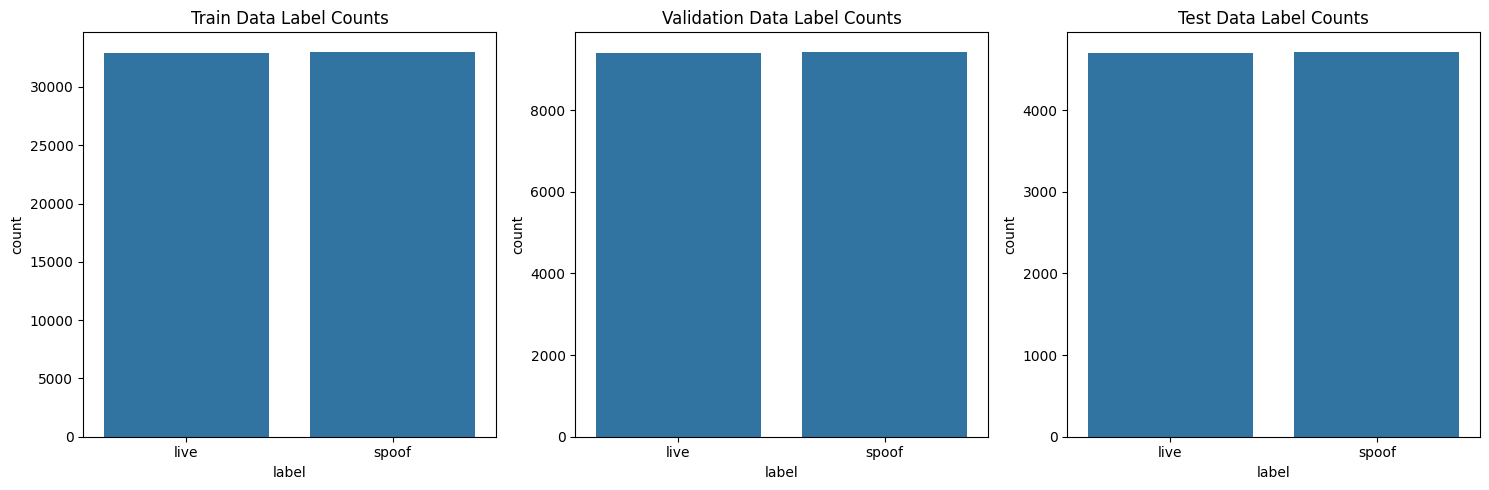

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot countplots for train_data, val_data, and test_data on subplots
sns.countplot(x='label', data=train_data, ax=axes[0])
axes[0].set_title('Train Data Label Counts')

sns.countplot(x='label', data=val_data, ax=axes[1])
axes[1].set_title('Validation Data Label Counts')

sns.countplot(x='label', data=test_data, ax=axes[2])
axes[2].set_title('Test Data Label Counts')

# Adjust layout
plt.tight_layout()

plt.show()

In [89]:
train_data

,path,label
0,live\live_000000.jpg,live
1,live\live_000005.jpg,live
2,live\live_000009.jpg,live
3,live\live_000012.jpg,live
4,live\live_000017.jpg,live
...,...,...
65923,spoof\spoof_504430.png,spoof
65924,spoof\spoof_504432.png,spoof
65925,spoof\spoof_504433.png,spoof
65926,spoof\spoof_504434.png,spoof


In [35]:
train_data_live = train_data[train_data["label"]=="live"]
train_data_live.reset_index(drop=True, inplace=True)

train_data_spoof = train_data[train_data["label"]=="spoof"]
train_data_spoof.reset_index(drop=True, inplace=True)

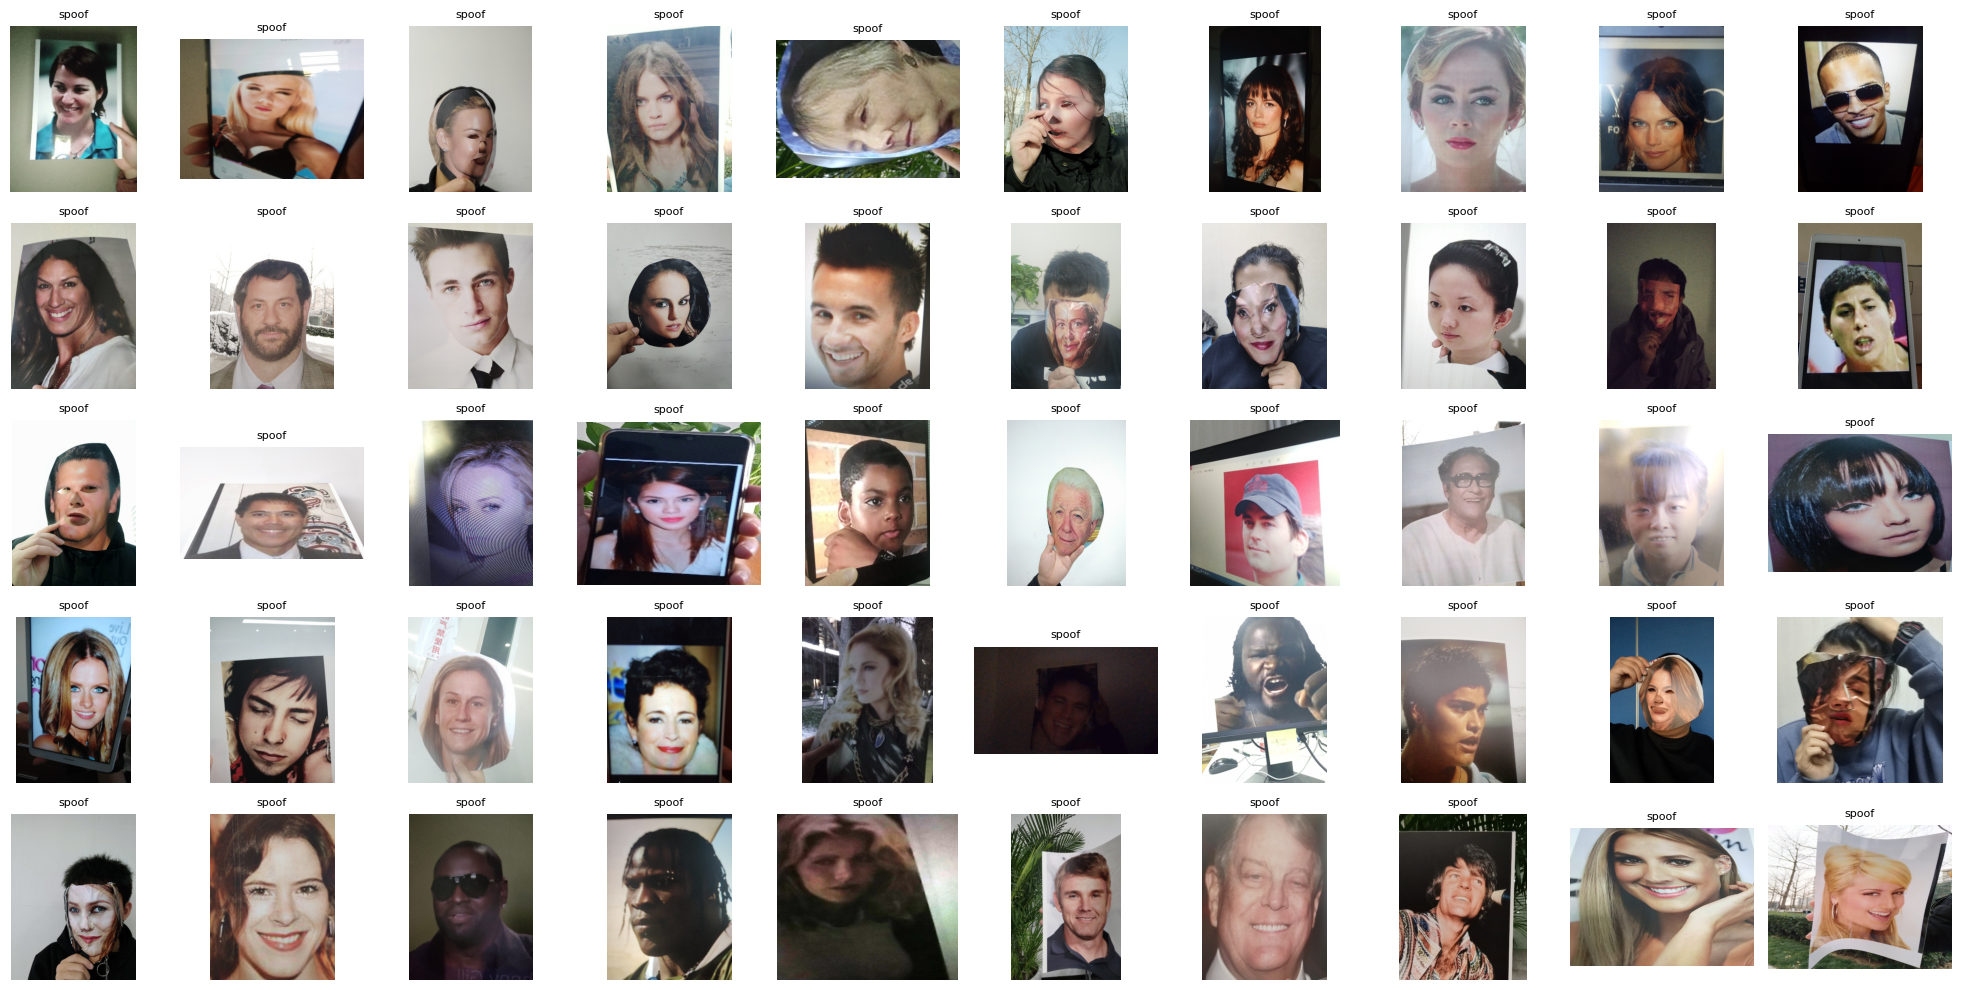

In [68]:
visualize_data(train_data_spoof, base_dir = "data_v2/train", rows=5, cols=10)

## Processing

In [90]:
def crop_image(image,data):
    print(data)
    biggest=0
    for faces in data:
        box=faces['box']            
        # calculate the area in the image
        area = box[3]  * box[2]
        if area>biggest:
            biggest=area
            bbox=box 
    bbox[0]= 0 if bbox[0]<0 else bbox[0]
    bbox[1]= 0 if bbox[1]<0 else bbox[1]
    image=image[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from bgr to rgb
    return image

In [164]:
def expand_bbox(bbox, img_width, img_height, expansion_rate=0.2):
    x, y, width, height = bbox

    # Calculate the expanded dimensions
    new_width = width * (1 + expansion_rate)
    new_height = height * (1 + expansion_rate)

    # Adjust the top-left corner coordinates
    new_x = x - (new_width - width) / 2
    new_y = y - (new_height - height) / 2

    # Ensure the coordinates are within the image bounds
    new_x = max(new_x, 0)
    new_y = max(new_y, 0)

    # Ensure the bottom-right corner does not go beyond the image
    if new_x + new_width > img_width:
        new_width = img_width - new_x
    if new_y + new_height > img_height:
        new_height = img_height - new_y

    return [int(new_x), int(new_y), int(new_width), int(new_height)]


In [177]:
def face_crop(model, image_path):
    img = cv2.imread(image_path)
    try:
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # detections = model.detect_faces(img_rgb)
            boxes, _, points_list = model.detect(img_rgb, landmarks=True)

            for box in boxes:
                bbox = list(map(int, box.tolist()))
                x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
                bbox = [x, y, width, width]
                expanded_bbox = expand_bbox(bbox, img_rgb.shape[1], img_rgb.shape[0], expansion_rate=0.4)  # Expand by 20%
                x, y, width, height = expanded_bbox
                cropped_face = img_rgb[y:y+height, x:x+width]
                
                cropped_face_bgr = cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR)           
                return cropped_face_bgr
            
    except Exception as e:
        # print(e)
        return img

In [ ]:
from mtcnn import MTCNN
import cv2
from facenet_pytorch import MTCNN


device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(thresholds= [0.7, 0.7, 0.8] ,keep_all=True, device = device)

In [180]:
for index, row in test_data.iterrows():
    image_path = "data_v2/test/" + row["path"]
    cropped_face = face_crop(mtcnn, image_path)
    
    if cropped_face.any:
        image_path_save = "face_croped/test/" + row["path"]
        cv2.imwrite(image_path_save, cropped_face)

In [31]:
device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(thresholds= [0.7, 0.7, 0.8] ,keep_all=True, device = device)

[9, 68, 199, 334]
[9, 68, 190, 190]


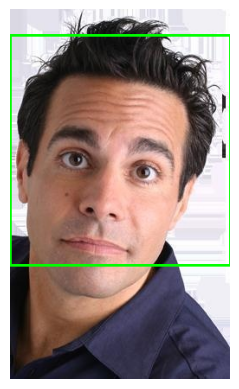

In [32]:
# Load the image using cv2.imread()
image_path = "data_v2/train/live/live_004402.jpg"  #train_data_live["path"][0]
img = cv2.imread(image_path)
# print(img)
# Check if the image was loaded successfully
if img is not None:
    # Convert the image to RGB color space
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces in the RGB image
    boxes, _, points_list = mtcnn.detect(img_rgb, landmarks=True)
    
    # Draw bounding boxes around the detected faces
    for box in boxes:
        # bbox = boxes['box']
        bbox = list(map(int, box.tolist()))
        print(bbox)
        x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        bbox = [x, y, width, width]
        print(bbox)
        expanded_bbox = expand_bbox(bbox, img_rgb.shape[1], img_rgb.shape[0], expansion_rate=0.4)  # Expand by 20%
        x, y, width, height = expanded_bbox
        cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.show()

[9, 68, 190, 190]
0 30 254 266


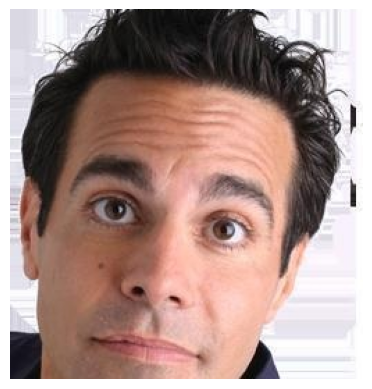

In [47]:
# Load the image using cv2.imread()
image_path = "data_v2/train/live/live_004402.jpg"  #train_data_live["path"][0]
img = cv2.imread(image_path)
# print(img)
# Check if the image was loaded successfully
if img is not None:
    # Convert the image to RGB color space
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces in the RGB image
    boxes, _, points_list = mtcnn.detect(img_rgb, landmarks=True)
    
    # Draw bounding boxes around the detected faces
    for box in boxes:
        # bbox = boxes['box']
        bbox = list(map(int, box.tolist()))
        # print(bbox)
        x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        bbox = [x, y, width, width]
        print(bbox)
        expanded_bbox = expand_bbox(bbox, img_rgb.shape[1], img_rgb.shape[0], expansion_rate=0.4)  # Expand by 20%
        x, y, width, height = expanded_bbox
        print(x, y, width, height)
        cropped_face = img[y:y+height, x:x+width]

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))
    plt.axis('off')  # Hide axis
    plt.show()

In [ ]:
def run(df, base_dir, face_model):
    for index, row in df.iterrows():
        image_path = base_dir + row["path"]
        cropped_face = face_crop(face_model, image_path)
        
        if cropped_face.any:
            image_path_save = "face_croped/test/" + row["path"]
            cv2.imwrite(image_path_save, cropped_face)
         

In [ ]:
run(train_data, "data_v2/train/", mtcnn)